<H2>Overview--Spam Classification</H2>

This notebook reads in a CSV file containing about 4600 lines of data describing email with 57 characteristics (certain word frequencies, number of exclamation points, number of consecutive capital letters, etc.), and one last column indicating whether the email was identified as spam or not (1 for spam, 0 for non-spam).  The notebook then attempts various classification methods to try to learn a method that will correctly identify the spam email.  Note, in this classification, it is more critical to avoid mis-classifying a real email as spam (false positive) than it is to let a spam email pass through.


We start by reading in header data from spambase.headers.txt and spam data from spambase.data.txt (the notebook assumes these files are in the folder that the notebook program was started from).


In [137]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
headers = pd.read_csv('spambase.headers.txt').columns
df = pd.read_csv('spambase.data.txt', names = headers)

<H2>Data Clean Up</H2>

We will check if NAN's are uploaded file, as well see what the Max and Min values are to see if we have outliers or potential bad data in columns.  

From the results, we see that no NAN clean up is needed.  And while most numerical results are sensible, we do see three columns with distinctly high counts, and they are all related to the number of consecutive capitals.  Lets look at the capital_run_length_total column which contains the number of uninterrupted capitals in a row. This will be investigated in the next section.

In [138]:
print df.isnull().values.any()
print df.max()
print df.min()

False
word_freq_make                    4.540
word_freq_address                14.280
word_freq_all                     5.100
word_freq_3d                     42.810
word_freq_our                    10.000
word_freq_over                    5.880
word_freq_remove                  7.270
word_freq_internet               11.110
word_freq_order                   5.260
word_freq_mail                   18.180
word_freq_receive                 2.610
word_freq_will                    9.670
word_freq_people                  5.550
word_freq_report                 10.000
word_freq_addresses               4.410
word_freq_free                   20.000
word_freq_business                7.140
word_freq_email                   9.090
word_freq_you                    18.750
word_freq_credit                 18.180
word_freq_your                   11.110
word_freq_font                   17.100
word_freq_000                     5.450
word_freq_money                  12.500
word_freq_hp                     2

<H2>Plot of Consecutive Capitals</H2>

We plot a histogram of the consecutive capitals. 

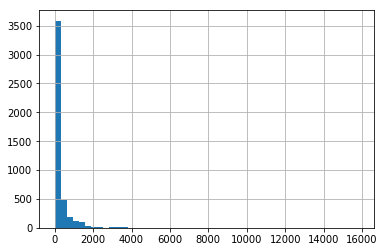

In [139]:
%matplotlib inline
import matplotlib.pyplot as plt
df['capital_run_length_total'].hist(bins = 50)
plt.show()

<H2>Examination of Consecutive Capitals</H2>
From that plot we see that there are almost no rows where the number of uninterrupted capitals is greater than 4000.  If we filter by that, we see that are only 8 rows with capitals greater than 4000, and only 5 with greater than 9000k.  We may want to look at filtering such rows later when we create prediction models against the training set as these may distort the model.

In [140]:
df.capital_run_length_total[df.capital_run_length_total>4000]

675      9088
679      9090
904      9163
1121     4128
1488    15841
1753    10062
1813     5902
3185     5395
Name: capital_run_length_total, dtype: int64

<H2>Histogram of All Predictors</H2>

All fields are numeric, lets look at historgrams of them to get an idea of the data we have imported, and which fields perhaps would be the most useful to use later in prediction models.  

One thing obvious, is they are all right tailed, because everything starts at zero and that is the most common occurence for any of the plots...obviously for each attribute, not having that attribute is the most common value.

The other obvious items is values are on quite different scales, so a future step will need to normalize or scale those columns so we are dealing with the same ranges for all columns.

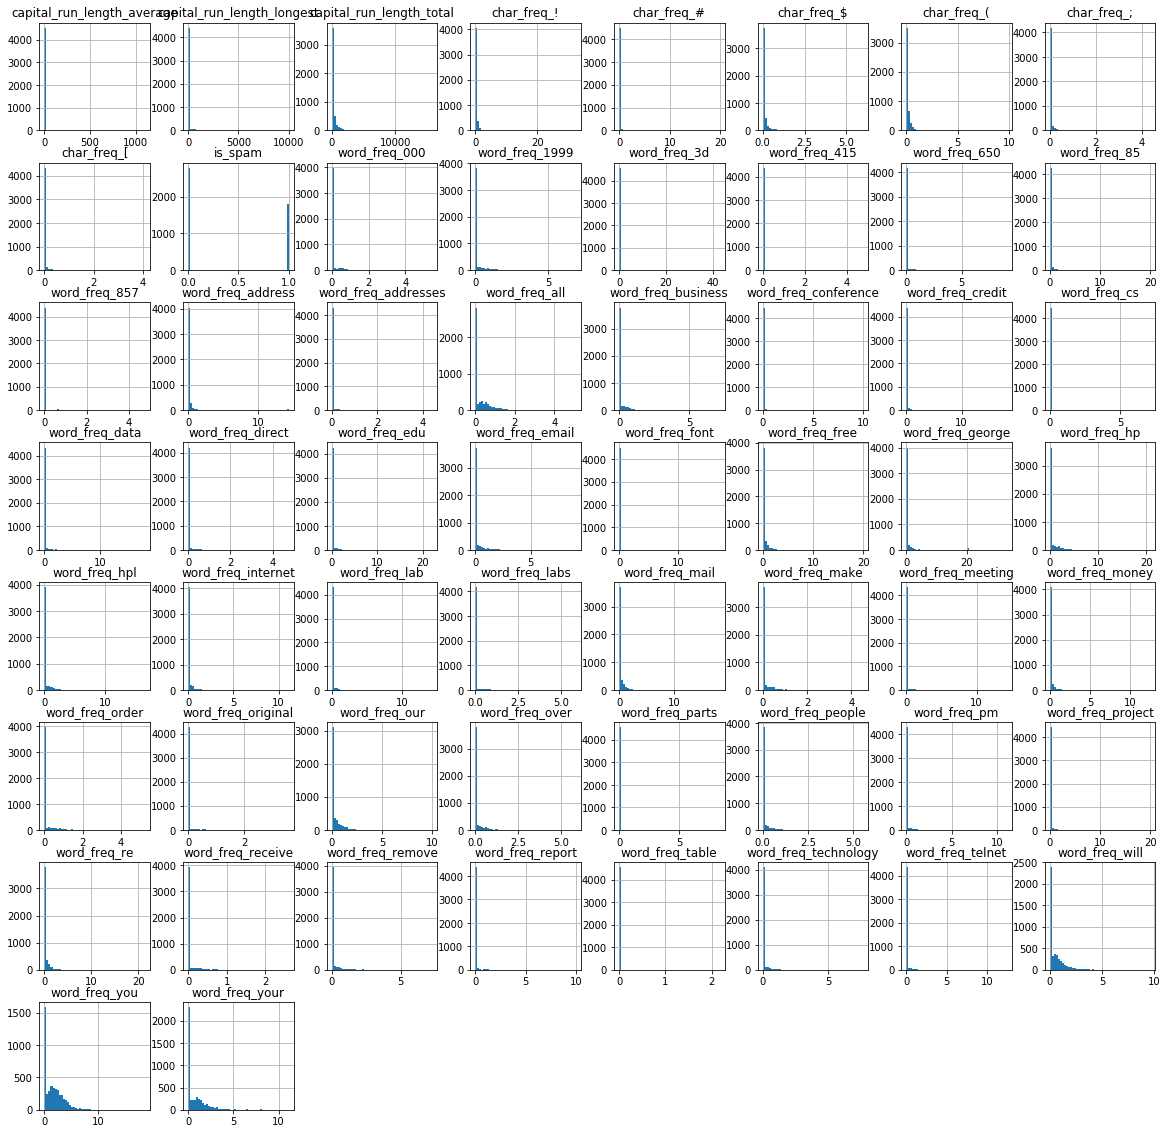

In [141]:
df.hist(bins = 50, figsize = (20,20))
plt.show()

<H2>Split up Data</H2>

Split up data into training dev_test and test datasets.  Set random state to 42 (of course) so tests are repeatable.

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
df = shuffle(df, random_state = 42)
dfTrain, dfTest = train_test_split(df, test_size = .20, random_state=42)
dfDevtest, dfTest = train_test_split(dfTest, test_size = .50, random_state=42)

<H2>Correlation</H2>

Examine correlation between various columns and the is_spam column, to see which columns seem to relate most (positively or negatively) to whether an email is spam.

From this we see that there a number of fields that correlate less than 10%  (either positive or negative).  If we trained this on a large enough dataset, if might make sense to scrap some of those columns to speed the training.  As it turned out with our analysis here the dataset was small enough that computational efficiency was not a concern.

In [143]:
correlation = dfTrain.corr()
correlation['is_spam'].sort_values()

word_freq_hp                 -0.250245
word_freq_hpl                -0.219168
word_freq_1999               -0.186568
word_freq_george             -0.182033
word_freq_labs               -0.161309
word_freq_edu                -0.145819
word_freq_650                -0.143788
word_freq_re                 -0.137717
word_freq_meeting            -0.137525
word_freq_85                 -0.135757
word_freq_technology         -0.132679
word_freq_original           -0.129761
word_freq_lab                -0.125540
word_freq_pm                 -0.121814
word_freq_data               -0.118778
word_freq_telnet             -0.115598
word_freq_857                -0.106829
word_freq_415                -0.105762
word_freq_project            -0.094904
word_freq_cs                 -0.093364
word_freq_conference         -0.081332
char_freq_(                  -0.076364
char_freq_[                  -0.070432
char_freq_;                  -0.061230
word_freq_direct             -0.057799
word_freq_table          

<H2>Scaling</H2>

We create a function to scale all the data to unit values, as many of the various classification techniques we try, do not work well otherwise.

In [144]:
from sklearn.preprocessing import StandardScaler
def getScaledData(df):
    isSpam = df.is_spam
    df = df.drop('is_spam', axis = 1)  #remove spam column before transforming, as we don't scale this categorical column
    scaler = StandardScaler()
    columns = df.columns
    df = scaler.fit_transform(df)
    df = pd.DataFrame(df, columns=columns)
    df['is_spam'] = isSpam.values
    return df
dfTrain = getScaledData(dfTrain)

<H2>First Training, Logistic Regression</H2>

Here We train a logistic regression model.

In [145]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='sag')
lr.fit(dfTrain.drop('is_spam', axis=1), dfTrain.is_spam)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

<H2>Logistic Regression Results</H2>

As we look at our results they are not bad from a standpoint of accuracy and filtering out spam.  We achieve over 93% accuracy on our test set, and only 10% of spam is passed through as good email.  But we are mis-classifying about 4% of good email as spam.  This is problematic as this means useful email would be missed by the receiver (unless they went to trouble of looking in spam folder).

In [146]:
def printResults(df, predictions):     
    print 'Accuracy of Model: ' + str(len(df[df['is_spam'] == predictions])/float(len(df)))
    numFalsePositive = len(df[(df['is_spam'] == 0) & (df['is_spam'] != predictions)])
    print 'The number of false positives was: ' + str(numFalsePositive)
    print 'The percentage of false positives was: ' + str(numFalsePositive/float(len(df[df['is_spam']==0])))

    numFalseNegative = len(df[(df['is_spam'] == 1) & (df['is_spam'] != predictions)])
    print 'The number of false negatives was: ' + str(numFalseNegative)
    print 'The percentage of false negatives was: ' + str(numFalseNegative/float(len(df[df['is_spam']==1])))

import numpy as np
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
dfTest = getScaledData(dfTest)
spam_predict = lr.predict(dfTest.drop('is_spam', axis = 1))

printResults(dfTest, spam_predict)

Accuracy of Model: 0.934924078091
The number of false positives was: 11
The percentage of false positives was: 0.0404411764706
The number of false negatives was: 19
The percentage of false negatives was: 0.100529100529


<H2>Logistic Refinement?</H2>

Since we can return results as probabilities that an email is spam, rather than stating outright that the email is or is not spam, we can easily change the filter by stating an email is spam at probablities higher than 50%.  We see if we increase the threshold to 75% spam we can reduce the number of false positives to 6 or about 2%, a clear improvement.  But by doing so we also  increase the number of false negatives by a factor of over 2 to almost 22%.  

The false postives isn't too bad, so perhaps this could be considered acceptable since we still eliminate the majority of spam.  But we are not likely to make things better using this method.  IF we look at the probabilities for false positives, we see that a number of them have a prediction of over 99% probability of being spam and the rest are over 90%.  Meaning to truly make sure we don't have any false positives by raising the threshold, we'd essentially end up letting all spam through and the spam filter would be useless.

In [147]:
probs = lr.predict_proba(dfTest.drop('is_spam', axis = 1))
spam_predict = probs[:,1] >0.75

printResults(dfTest, spam_predict)
print 'The predicted probablity of the remaining false positives was: \r\n ' + \
        str(probs[dfTest[(dfTest['is_spam'] == 0) & (dfTest['is_spam'] != spam_predict)].index.values][:,1])

Accuracy of Model: 0.898047722343
The number of false positives was: 6
The percentage of false positives was: 0.0220588235294
The number of false negatives was: 41
The percentage of false negatives was: 0.216931216931
The predicted probablity of the remaining false positives was: 
 [0.997703 0.978260 0.900527 0.914584 0.987742 0.999957]


<H2>Try SGD</H2>

Below we try a Stochastic Gradient Descent Classifier.  It achieves accuracy of over 93% overall, but false postive (where emails were identified as spam when they were good (non-spam) emails were at 4.4% which is worse than the logistic regression  So we are not at a good model yet.

In [148]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state = 42, n_iter = 500)
#drop spam column
dfXData = dfTrain.drop('is_spam', axis = 1)
yData = dfTrain.is_spam.values
sgd.fit(dfXData, yData)

spam_predict = sgd.predict(dfTest.drop('is_spam', axis = 1))
printResults(dfTest, spam_predict)

Accuracy of Model: 0.937093275488
The number of false positives was: 12
The percentage of false positives was: 0.0441176470588
The number of false negatives was: 17
The percentage of false negatives was: 0.0899470899471


<H2>SGD with Probablities</H2>

We quickly try SGD using probabilites to see if that can help.  We reduce the number of false postives slighly, but are still at 3.3% and we are letting over 21% of spam through.

In [149]:
sgd = SGDClassifier(random_state = 42, n_iter = 500, loss = 'log')
sgd.fit(dfXData, yData)
probs = sgd.predict_proba(dfTest.drop('is_spam', axis = 1))
spam_predict = probs[:,1] >0.75

print 'The predicted probablity of the false positives are: \r\n ' + \
        str(probs[dfTest[(dfTest['is_spam'] == 0) & (dfTest['is_spam'] != spam_predict)].index.values][:,1])



printResults(dfTest, spam_predict)

The predicted probablity of the false positives are: 
 [0.998402 0.963199 0.899831 0.999832 0.780057 0.928006 0.760047 0.990048
 0.999950]
Accuracy of Model: 0.893709327549
The number of false positives was: 9
The percentage of false positives was: 0.0330882352941
The number of false negatives was: 40
The percentage of false negatives was: 0.21164021164


<H2>Cross-Fold Validation</H2>

Let's try doing a cross-fold validation to see how our model is doing and see if there is an issue uncovered by that.

As we see that scores are about the same for train and test, it is unlikely we are overfitting to any substantive degree.

In [150]:
from sklearn.model_selection import cross_validate
cvScores = cross_validate(sgd, dfXData, yData, cv=10)
print cvScores['test_score'].mean()
print cvScores['train_score'].mean()


0.9244496210585256
0.9289251273046553


<H2>SVM</H2>

Let's try a different classifier, Support Vector Classifier (SVC).  Using this we get marginally less false positives, but false negatives were down to under 8%, so maybe we are onto something with this classifier.

In [151]:
from sklearn import svm
dfXData = dfTrain.drop('is_spam', axis = 1)
yData = dfTrain.is_spam.values
clf = svm.SVC()
clf.fit(dfXData, yData)  
spam_predict = clf.predict(dfTest.drop('is_spam', axis = 1))

printResults(dfTest, spam_predict)

Accuracy of Model: 0.943600867679
The number of false positives was: 11
The percentage of false positives was: 0.0404411764706
The number of false negatives was: 15
The percentage of false negatives was: 0.0793650793651


<H2>SVC Using Probabilities</H2>

Using a 75% threshold, we are now down to 2.2% false positives and we are under 15% false negatives, so we are definitely improving here.

In [152]:
clf = svm.SVC(probability=True)
clf.fit(dfXData, yData) 
probs = clf.predict_proba(dfTest.drop('is_spam', axis = 1))

print 'The predicted probablity of the false positives are: \r\n ' + \
        str(probs[dfTest[(dfTest['is_spam'] == 0) & (dfTest['is_spam'] != spam_predict)].index.values][:,1])

spam_predict = probs[:,1] >0.75

printResults(dfTest, spam_predict)

The predicted probablity of the false positives are: 
 [0.999999 0.591521 0.794395 0.989127 0.538141 0.885841 0.590634 0.580456
 0.960597 0.522768 0.928144]
Accuracy of Model: 0.926247288503
The number of false positives was: 6
The percentage of false positives was: 0.0220588235294
The number of false negatives was: 28
The percentage of false negatives was: 0.148148148148


<H2>Tune HyperParameters</H2>

Since we have improved, lets run the GridSearchCV method with a few parameters to test for to see if we can find a more optimum set to use for the SVC classifier.  This takes quite some time even with setting the n_jobs option...so if running this step be patient.

In [153]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=5, n_jobs=6)                        

clf.fit(dfXData, yData);

<H2>Tuning Results</H2>

Printing the tuning results, shows us that the best parameters are a Kernel of RBF (Radial Basis Function) a penalty parameter (C) of 1000, and a gamma value of .001.

In [154]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"  % (mean, std * 2, params))

0.901 (+/-0.013) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.799 (+/-0.011) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.925 (+/-0.010) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.898 (+/-0.013) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.931 (+/-0.006) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
0.921 (+/-0.014) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
0.932 (+/-0.011) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
0.929 (+/-0.013) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}
0.928 (+/-0.011) for {'kernel': 'linear', 'C': 1}
0.927 (+/-0.013) for {'kernel': 'linear', 'C': 10}
0.929 (+/-0.013) for {'kernel': 'linear', 'C': 100}
0.930 (+/-0.012) for {'kernel': 'linear', 'C': 1000}


<H2>Good Results!</H2>

Using the tuned hyper parameters and a standard greater than even probability we are down to under 3% false positive and just above 8% false negative.

Looking at the probablities of the false positives, we see that a value of 70% might be optimal for elminating as many false postives as possible without unduly letting too much spamm through.  Doing so gives us a false positive rate of only 1.1% and false negative at under 15%.

In [155]:
clf = svm.SVC(probability=True, kernel = 'rbf', C = 1000, gamma=.001)
clf.fit(dfXData, yData) 
probs = clf.predict_proba(dfTest.drop('is_spam', axis = 1))

spam_predict = probs[:,1] >0.5
printResults(dfTest, spam_predict)
print 'The predicted probablity of the false positives are: \r\n ' + \
        str(probs[dfTest[(dfTest['is_spam'] == 0) & (dfTest['is_spam'] != spam_predict)].index.values][:,1])

spam_predict = probs[:,1] >0.70
printResults(dfTest, spam_predict)
print 'The predicted probablity of the false positives are: \r\n ' + \
        str(probs[dfTest[(dfTest['is_spam'] == 0) & (dfTest['is_spam'] != spam_predict)].index.values][:,1])


Accuracy of Model: 0.947939262473
The number of false positives was: 8
The percentage of false positives was: 0.0294117647059
The number of false negatives was: 16
The percentage of false negatives was: 0.0846560846561
The predicted probablity of the false positives are: 
 [0.999999 0.632444 0.926868 0.642960 0.597745 0.561734 0.880129 0.633161]
Accuracy of Model: 0.932754880694
The number of false positives was: 3
The percentage of false positives was: 0.0110294117647
The number of false negatives was: 28
The percentage of false negatives was: 0.148148148148
The predicted probablity of the false positives are: 
 [0.999999 0.926868 0.880129]


<H2>Retest on DevTest data</H2>

Run the same test on the DevTest set of data that was set aside long ago.  On this set of data, the false postives were uner 1%!  False negatives were a bit higher at about 17%, but overall it is validating that our model works fairly well.

In [156]:
dfDevtest = getScaledData(dfDevtest)
probs = clf.predict_proba(dfDevtest.drop('is_spam', axis = 1))


spam_predict = probs[:,1] >0.5
printResults(dfDevtest, spam_predict)

spam_predict = probs[:,1] >0.70
printResults(dfDevtest, spam_predict)

Accuracy of Model: 0.945652173913
The number of false positives was: 4
The percentage of false positives was: 0.0151515151515
The number of false negatives was: 21
The percentage of false negatives was: 0.107142857143
Accuracy of Model: 0.919565217391
The number of false positives was: 2
The percentage of false positives was: 0.00757575757576
The number of false negatives was: 35
The percentage of false negatives was: 0.178571428571
